<a href="https://colab.research.google.com/github/mirza019/Speech-Emotion-Recognition-using-MFCC-and-Wav2Vec2/blob/main/Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install -U datasets torchcodec torch torchvision torchaudio librosa scikit-learn matplotlib -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 721.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32

In [3]:
# ==========================================================
# Speech Emotion Recognition using Hugging Face RAVDESS
# ==========================================================

import os, numpy as np, torch, torch.nn as nn, librosa, matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ----------------------------------------------------------
# Load the dataset directly from Hugging Face
# ----------------------------------------------------------
from huggingface_hub import login
login()   # paste your token string here



In [8]:
url = "https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip"
if not os.path.exists("ravdess.zip"):
    print("⬇️  Downloading RAVDESS dataset (~1 GB, first run only)...")
    wget.download(url, "ravdess.zip")
with zipfile.ZipFile("ravdess.zip", "r") as zip_ref:
    zip_ref.extractall("ravdess")

print("Dataset extracted to:", os.path.abspath("ravdess"))

Dataset extracted to: /content/ravdess


In [2]:
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None, mono=True, duration=3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)


In [1]:
import datasets, torchcodec
print(" Both datasets and torchcodec are ready")

 Both datasets and torchcodec are ready


In [4]:



X, y = [], []
for root, _, files in os.walk("ravdess"):
    for f in files:
        if f.endswith(".wav"):
            emotion_code = f.split("-")[2]
            if emotion_code in emotion_map:
                X.append(extract_features(os.path.join(root, f)))
                y.append(emotion_map[emotion_code])

X, y = np.array(X), np.array(y)
print(f"Loaded {len(X)} samples with emotions:", sorted(set(y)))


Loaded 1440 samples with emotions: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]


In [5]:

# ----------------------------------------------------------
# Prepare data
# ----------------------------------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)


In [6]:

# ----------------------------------------------------------
# Define & train model
# ----------------------------------------------------------
class SERNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(40, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_classes)
        self.relu, self.drop = nn.ReLU(), nn.Dropout(0.3)
    def forward(self, x):
        x = self.drop(self.relu(self.fc1(x)))
        x = self.drop(self.relu(self.fc2(x)))
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SERNet(len(np.unique(y_encoded))).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()


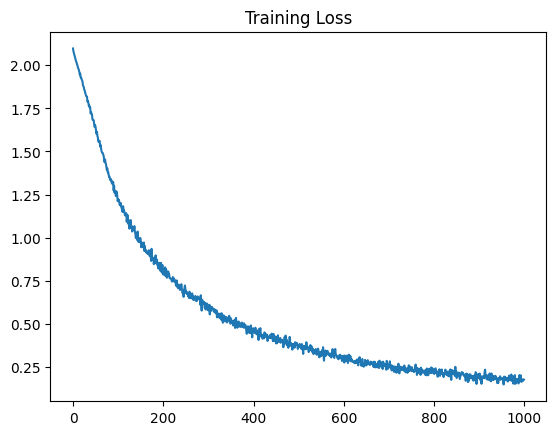

In [7]:

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)

losses = []
for epoch in range(1000):
    opt.zero_grad()
    out = model(X_train_t)
    loss = loss_fn(out, y_train_t)
    loss.backward(); opt.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()


In [8]:

# ----------------------------------------------------------
# Evaluate
# ----------------------------------------------------------
model.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)
with torch.no_grad():
    preds = torch.argmax(model(X_test_t), dim=1)
    acc = (preds == y_test_t).float().mean().item()

print(f"✅ Test Accuracy: {acc*100:.2f}%")
print("Emotion Labels:", list(le.classes_))
for i in range(10):
    print(f"Pred={le.inverse_transform([preds[i].cpu()])[0]} | True={le.inverse_transform([y_test_t[i].cpu()])[0]}")


✅ Test Accuracy: 70.00%
Emotion Labels: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]
Pred=angry | True=angry
Pred=surprised | True=surprised
Pred=angry | True=angry
Pred=sad | True=fearful
Pred=fearful | True=fearful
Pred=surprised | True=disgust
Pred=calm | True=calm
Pred=sad | True=disgust
Pred=disgust | True=disgust
Pred=fearful | True=fearful


In [11]:

# ----------------------------------------------------------
# Test your own .wav
# ----------------------------------------------------------
from google.colab import files
print("\n🎤 Upload a WAV file (<5 s) to test emotion:")
uploaded = files.upload()

for fn in uploaded.keys():
    feat = extract_features(fn)
    feat = scaler.transform([feat])
    with torch.no_grad():
        pred = torch.argmax(model(torch.tensor(feat, dtype=torch.float32).to(device)), dim=1)
    print(f"🔎 Predicted Emotion for '{fn}': {le.inverse_transform([pred.cpu().item()])[0]}")



🎤 Upload a WAV file (<5 s) to test emotion:


Saving download (1).wav to download (1) (1).wav
Saving download (2).wav to download (2) (1).wav
Saving download (3).wav to download (3) (1).wav
Saving download (4).wav to download (4) (1).wav
Saving download (5).wav to download (5) (1).wav
Saving download (6).wav to download (6) (1).wav
Saving download (7).wav to download (7).wav
Saving download (8).wav to download (8).wav
🔎 Predicted Emotion for 'download (1) (1).wav': disgust
🔎 Predicted Emotion for 'download (2) (1).wav': disgust
🔎 Predicted Emotion for 'download (3) (1).wav': fearful
🔎 Predicted Emotion for 'download (4) (1).wav': disgust
🔎 Predicted Emotion for 'download (5) (1).wav': fearful
🔎 Predicted Emotion for 'download (6) (1).wav': disgust
🔎 Predicted Emotion for 'download (7).wav': disgust
🔎 Predicted Emotion for 'download (8).wav': disgust


In [10]:
# ==========================================================
# Fine-tune Wav2Vec2 on RAVDESS Emotion Dataset
# ==========================================================

!pip install transformers torchaudio librosa wget scikit-learn torch torchvision tqdm -q


In [12]:

import os, wget, zipfile, torch, librosa, numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm

# ----------------------------------------------------------
# Load pretrained Wav2Vec2 processor + model
# ----------------------------------------------------------
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")

# Freeze backbone
for p in wav2vec.parameters():
    p.requires_grad = False


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
25it [25:37, 61.49s/it]

✅ Extracted 1440 embeddings for 8 emotions: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]
Epoch 01 | Loss = 2.1064
Epoch 02 | Loss = 1.8979
Epoch 03 | Loss = 1.7741
Epoch 04 | Loss = 1.6620
Epoch 05 | Loss = 1.5925
Epoch 06 | Loss = 1.5246
Epoch 07 | Loss = 1.4751
Epoch 08 | Loss = 1.4234
Epoch 09 | Loss = 1.3829
Epoch 10 | Loss = 1.3369
Epoch 11 | Loss = 1.3171
Epoch 12 | Loss = 1.2642
Epoch 13 | Loss = 1.2259
Epoch 14 | Loss = 1.1926
Epoch 15 | Loss = 1.1643
Epoch 16 | Loss = 1.1419
Epoch 17 | Loss = 1.1015
Epoch 18 | Loss = 1.0761
Epoch 19 | Loss = 1.0637
Epoch 20 | Loss = 1.0250

✅ Test Accuracy: 47.22%
Emotion labels: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]


In [ ]:

# ----------------------------------------------------------
# Extract features from each WAV
# ----------------------------------------------------------
def extract_features(file):
    y, sr = librosa.load(file, sr=16000, mono=True)
    inputs = processor(y, sampling_rate=16000, return_tensors="pt", padding=True)
    with torch.no_grad():
        hidden = wav2vec(**inputs).last_hidden_state
    # mean-pool to get single embedding
    return hidden.mean(dim=1).squeeze().cpu().numpy()

X, y = [], []
for root, _, files in tqdm(os.walk("ravdess")):
    for f in files:
        if f.endswith(".wav"):
            emo_code = f.split("-")[2]
            if emo_code in emotion_map:
                y.append(emotion_map[emo_code])
                X.append(extract_features(os.path.join(root, f)))

X, y = np.array(X), np.array(y)
print(f"Extracted {len(X)} embeddings for {len(set(y))} emotions: {sorted(set(y))}")


In [ ]:

# ----------------------------------------------------------
# Prepare data
# ----------------------------------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train, X_test = scaler.fit_transform(X_train), scaler.transform(X_test)


In [ ]:

# ----------------------------------------------------------
# Simple classifier on top of Wav2Vec2 features
# ----------------------------------------------------------
class Head(nn.Module):
    def __init__(self, in_dim, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 256)
        self.fc2 = nn.Linear(256, n_classes)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
    def forward(self, x):
        x = self.drop(self.relu(self.fc1(x)))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf = Head(768, len(le.classes_)).to(device)

opt = torch.optim.Adam(clf.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)


In [ ]:

# ----------------------------------------------------------
# Train
# ----------------------------------------------------------
for epoch in range(20):
    clf.train(); opt.zero_grad()
    out = clf(X_train_t)
    loss = loss_fn(out, y_train_t)
    loss.backward(); opt.step()
    print(f"Epoch {epoch+1:02d} | Loss = {loss.item():.4f}")


In [14]:

# ----------------------------------------------------------
# Evaluate
# ----------------------------------------------------------
clf.eval()
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)
with torch.no_grad():
    preds = torch.argmax(clf(X_test_t), dim=1)
acc = (preds == y_test_t).float().mean().item()

print(f"\nTest Accuracy: {acc*100:.2f}%")
print("Emotion labels:", list(le.classes_))



Test Accuracy: 47.22%
Emotion labels: [np.str_('angry'), np.str_('calm'), np.str_('disgust'), np.str_('fearful'), np.str_('happy'), np.str_('neutral'), np.str_('sad'), np.str_('surprised')]


In [16]:
from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]

feat = extract_features(fname)
feat = scaler.transform([feat])
with torch.no_grad():
    pred = torch.argmax(clf(torch.tensor(feat, dtype=torch.float32).to(device)), dim=1)
print(f"Predicted emotion: {le.inverse_transform([pred.cpu().item()])[0]}")


Saving download (4).wav to download (4) (3).wav
🔎 Predicted emotion: disgust


In [17]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace Speech.ipynb


[NbConvertApp] WARNING | pattern 'Speech.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Exec